In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Load the CSV dataset
data = pd.read_csv('wdbc.csv')

X = data.iloc[:, 2:].values  # Feature columns
y = data.iloc[:, 1].values.reshape(-1, 1)  # Label column

# Normalize the feature columns
X = (X - X.mean(axis=0)) / X.std(axis=0)

# Convert the labels to one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the training data into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Initialize the ANN model parameters
input_size = X_train.shape[1]
hidden_size = 5
output_size = y_train.shape[1]

In [236]:
print(y_train.shape[1])

2


In [3]:
print(data.shape)

(569, 32)


In [4]:
data.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
print(X_train.shape)
print(y_train.shape)
#print(X_val.shape)
#print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(455, 30)
(455, 2)
(114, 30)
(114, 2)


In [6]:
# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / exp_x.sum(axis=1, keepdims=True)

# Forward propagation
def forward_propagation(X, W1, b1, W2, b2):
    z1 = np.dot(X, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    a2 = softmax(z2)
    return a1, a2

# Backward propagation
def backward_propagation(X, y, a1, a2, W1, W2):
    m = X.shape[0]
    dz2 = a2 - y
    dW2 = np.dot(a1.T, dz2) / m
    db2 = np.sum(dz2, axis=0, keepdims=True) / m
    dz1 = np.dot(dz2, W2.T) * sigmoid_derivative(a1)
    dW1 = np.dot(X.T, dz1) / m
    db1 = np.sum(dz1, axis=0, keepdims=True) / m
    return dW1, db1, dW2, db2

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler



def compute_accuracy(predictions, labels):
    return accuracy_score(np.argmax(labels, axis=1), np.argmax(predictions, axis=1))

# Hyperparameters
num_initializations = 10
learning_rates = [0.001, 0.01, 0.05, 0.1,0.2]
epochs = 1000
patience = 10
# Store the original training data
X_train_original = X_train
y_train_original = y_train


# Initialize matrix to store updated weights and biases
updated_weights_biases = np.zeros((len(learning_rates), num_initializations,input_size * hidden_size + hidden_size + hidden_size * output_size + output_size))


# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize matrix to store updated weights and biases
results = []
for train_index, val_index in kf.split(X_train_original): # Use the original X_train for splitting
    X_train_fold, X_val = X_train_original[train_index], X_train_original[val_index]
    y_train_fold, y_val = y_train_original[train_index], y_train_original[val_index]


    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    for lr_idx, learning_rate in enumerate(learning_rates):
        for init_idx in range(num_initializations):
            # Retrieve initial weights and biases
            W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)  # Xavier initialization
            b1 = np.zeros((1, hidden_size))
            W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)  # Xavier initialization
            b2 = np.zeros((1, output_size))

            # Training process with backpropagation
            best_val_loss = float('inf')
            best_train_loss = float('inf')
            best_train_accuracy = 0
            best_val_accuracy = 0
            patience_counter = 0

            for epoch in range(epochs):
                # Forward propagation
                a1_train, a2_train = forward_propagation(X_train, W1, b1, W2, b2)
                a1_val, a2_val = forward_propagation(X_val, W1, b1, W2, b2)

                # Compute training and validation loss
                train_loss = np.mean((a2_train - y_train) ** 2)
                val_loss = np.mean((a2_val - y_val) ** 2)

                # Compute training and validation accuracy
                train_accuracy = compute_accuracy(a2_train, y_train)
                val_accuracy = compute_accuracy(a2_val, y_val)

                # Backward propagation
                dW1, db1, dW2, db2 = backward_propagation(X_train, y_train, a1_train, a2_train, W1, W2)

                # Update weights and biases
                W1 -= learning_rate * dW1
                b1 -= learning_rate * db1
                W2 -= learning_rate * dW2
                b2 -= learning_rate * db2

                # Track best validation loss and accuracy
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_train_loss = train_loss
                    best_train_accuracy = train_accuracy
                    best_val_accuracy = val_accuracy
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print(f"Early stopping at epoch {epoch + 1} for learning rate {learning_rate}")
                        break

                # Print training and validation metrics
                if epoch % 100 == 0:  # Print every 100 epochs
                    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
            # Store the updated weights and biases
            idx = (lr_idx, init_idx)
            updated_weights_biases[idx[0], idx[1], :] = np.concatenate([W1.flatten(), b1.flatten(), W2.flatten(), b2.flatten()])

            results.append({
                'learning_rate': learning_rate,
                'initialization':init_idx,
                'fold': len(results) // (num_initializations * len(learning_rates)) + 1,
                'train_loss': best_train_loss,
                'train_accuracy': best_train_accuracy,
                'val_loss': best_val_loss,
                'val_accuracy': best_val_accuracy
            })

# Aggregate results
import pandas as pd
results_df = pd.DataFrame(results)
mean_results = results_df.groupby(['learning_rate', 'initialization']).mean()

print(mean_results)


Epoch 1/1000 - Train Loss: 0.4296, Train Accuracy: 0.3714, Val Loss: 0.4203, Val Accuracy: 0.3956
Epoch 101/1000 - Train Loss: 0.3927, Train Accuracy: 0.3714, Val Loss: 0.3868, Val Accuracy: 0.3956
Epoch 201/1000 - Train Loss: 0.3572, Train Accuracy: 0.3714, Val Loss: 0.3547, Val Accuracy: 0.3956
Epoch 301/1000 - Train Loss: 0.3246, Train Accuracy: 0.3824, Val Loss: 0.3248, Val Accuracy: 0.4176
Epoch 401/1000 - Train Loss: 0.2954, Train Accuracy: 0.4088, Val Loss: 0.2979, Val Accuracy: 0.4396
Epoch 501/1000 - Train Loss: 0.2699, Train Accuracy: 0.4462, Val Loss: 0.2742, Val Accuracy: 0.4396
Epoch 601/1000 - Train Loss: 0.2479, Train Accuracy: 0.5253, Val Loss: 0.2536, Val Accuracy: 0.4945
Epoch 701/1000 - Train Loss: 0.2291, Train Accuracy: 0.6000, Val Loss: 0.2360, Val Accuracy: 0.5604
Epoch 801/1000 - Train Loss: 0.2132, Train Accuracy: 0.6659, Val Loss: 0.2209, Val Accuracy: 0.6044
Epoch 901/1000 - Train Loss: 0.1998, Train Accuracy: 0.7231, Val Loss: 0.2081, Val Accuracy: 0.6813
Ep

In [8]:
 print(X_train.shape)
 print(y_train.shape)
 print(X_val.shape)
 print(y_val.shape)

(455, 30)
(455, 2)
(91, 30)
(91, 2)


In [9]:
# Print the matrix
print("Shape of the updated weights and biases matrix:", updated_weights_biases.shape)
print("Updated weights and biases matrix:")
print(updated_weights_biases)

Shape of the updated weights and biases matrix: (5, 10, 167)
Updated weights and biases matrix:
[[[-0.22957684  0.44709624  0.20670588 ...  1.59012343  0.28540357
   -0.28540357]
  [ 0.29616377 -0.09754563 -0.27140158 ... -1.32880739 -0.18803613
    0.18803613]
  [-0.09690713  0.28163799 -0.17360499 ...  0.40915746  0.32253474
   -0.32253474]
  ...
  [ 0.37710261  0.26877841 -0.2989743  ...  0.17967245 -0.12622952
    0.12622952]
  [ 0.03647079 -0.17374999 -0.35261195 ... -0.93554273  0.03921484
   -0.03921484]
  [ 0.16108269  0.26761214 -0.01564679 ...  0.62039547 -0.05670913
    0.05670913]]

 [[-0.29412367 -0.20501163 -0.21632109 ... -0.54192675 -0.70236712
    0.70236712]
  [ 0.32704375 -0.07089488  0.09837886 ...  0.55680455  0.44599614
   -0.44599614]
  [-0.39072507  0.33056313  0.01226628 ... -0.29973522 -0.68138175
    0.68138175]
  ...
  [-0.03287107  0.25941157 -0.37102298 ...  0.82085759  0.27574865
   -0.27574865]
  [ 0.2510877  -0.60465741  0.41133725 ... -0.14470714  0.39

In [10]:
class_probabilities = np.zeros((5, 10, X_test.shape[0], output_size))

# Extract weights and biases and compute class probabilities
for lr_idx in range(5):
    for init_idx in range(10):
        # Retrieve weights and biases
        W1 = updated_weights_biases[lr_idx, init_idx, :input_size * hidden_size].reshape(input_size, hidden_size)
        b1 = updated_weights_biases[lr_idx, init_idx, input_size * hidden_size:input_size * hidden_size + hidden_size].reshape(1, hidden_size)
        W2 = updated_weights_biases[lr_idx, init_idx, input_size * hidden_size + hidden_size:input_size * hidden_size + hidden_size + hidden_size * output_size].reshape(hidden_size, output_size)
        b2 = updated_weights_biases[lr_idx, init_idx, input_size * hidden_size + hidden_size + hidden_size * output_size:].reshape(1, output_size)

        # Compute class probabilities for test samples
        _, probs = forward_propagation(X_test, W1, b1, W2, b2)
        class_probabilities[lr_idx, init_idx, :, :] = probs

# Print class probabilities
for lr_idx in range(5):
    print(f"Learning rate = {learning_rates[lr_idx]}")
    for sample_idx in range(X_test.shape[0]):
        print(f"Sample {sample_idx + 1}", end=" ")
        for init_idx in range(10):
            print(f"Initialization {init_idx + 1}: ", end="")
            print(" ".join(f"{prob:.2f}" for prob in class_probabilities[lr_idx, init_idx, sample_idx]), end=" | ")
        print()  # Newline for each sample
    print()  # Newline for each learning rate

Learning rate = 0.001
Sample 1 Initialization 1: 0.46 0.54 | Initialization 2: 0.82 0.18 | Initialization 3: 0.47 0.53 | Initialization 4: 0.57 0.43 | Initialization 5: 0.71 0.29 | Initialization 6: 0.40 0.60 | Initialization 7: 0.52 0.48 | Initialization 8: 0.75 0.25 | Initialization 9: 0.64 0.36 | Initialization 10: 0.73 0.27 | 
Sample 2 Initialization 1: 0.23 0.77 | Initialization 2: 0.66 0.34 | Initialization 3: 0.26 0.74 | Initialization 4: 0.40 0.60 | Initialization 5: 0.61 0.39 | Initialization 6: 0.38 0.62 | Initialization 7: 0.27 0.73 | Initialization 8: 0.72 0.28 | Initialization 9: 0.68 0.32 | Initialization 10: 0.38 0.62 | 
Sample 3 Initialization 1: 0.21 0.79 | Initialization 2: 0.65 0.35 | Initialization 3: 0.28 0.72 | Initialization 4: 0.36 0.64 | Initialization 5: 0.68 0.32 | Initialization 6: 0.34 0.66 | Initialization 7: 0.37 0.63 | Initialization 8: 0.68 0.32 | Initialization 9: 0.62 0.38 | Initialization 10: 0.35 0.65 | 
Sample 4 Initialization 1: 0.55 0.45 | Initia

In [11]:
# Calculate min and max probabilities
for lr_idx in range(5):
    print(f"Learning rate = {learning_rates[lr_idx]}")
    for sample_idx in range(X_test.shape[0]):
        min_probs = np.min(class_probabilities[lr_idx, :, sample_idx, :], axis=0)
        max_probs = np.max(class_probabilities[lr_idx, :, sample_idx, :], axis=0)

        print(f"Sample {sample_idx + 1}: ", end="")
        for class_idx in range(output_size):
            print(f"Class {class_idx + 1}: ({min_probs[class_idx]:.2f}, {max_probs[class_idx]:.2f})", end=" | ")
        print()  # Newline for each sample
    print()  # Newline for each learning rate

Learning rate = 0.001
Sample 1: Class 1: (0.40, 0.82) | Class 2: (0.18, 0.60) | 
Sample 2: Class 1: (0.23, 0.72) | Class 2: (0.28, 0.77) | 
Sample 3: Class 1: (0.21, 0.68) | Class 2: (0.32, 0.79) | 
Sample 4: Class 1: (0.42, 0.81) | Class 2: (0.19, 0.58) | 
Sample 5: Class 1: (0.44, 0.90) | Class 2: (0.10, 0.56) | 
Sample 6: Class 1: (0.16, 0.49) | Class 2: (0.51, 0.84) | 
Sample 7: Class 1: (0.14, 0.59) | Class 2: (0.41, 0.86) | 
Sample 8: Class 1: (0.27, 0.74) | Class 2: (0.26, 0.73) | 
Sample 9: Class 1: (0.30, 0.63) | Class 2: (0.37, 0.70) | 
Sample 10: Class 1: (0.44, 0.93) | Class 2: (0.07, 0.56) | 
Sample 11: Class 1: (0.45, 0.89) | Class 2: (0.11, 0.55) | 
Sample 12: Class 1: (0.30, 0.80) | Class 2: (0.20, 0.70) | 
Sample 13: Class 1: (0.44, 0.93) | Class 2: (0.07, 0.56) | 
Sample 14: Class 1: (0.19, 0.68) | Class 2: (0.32, 0.81) | 
Sample 15: Class 1: (0.44, 0.91) | Class 2: (0.09, 0.56) | 
Sample 16: Class 1: (0.11, 0.58) | Class 2: (0.42, 0.89) | 
Sample 17: Class 1: (0.43, 

In [12]:
# Calculate min and max probabilities
alpha = 0.5  # Example value, adjust as needed
beta=0.5

# Initialize matrices to store F and G values
F_values = np.zeros((5, X_test.shape[0], output_size))
G_values = np.zeros((5, X_test.shape[0], output_size))

F_G_values = np.zeros((X_test.shape[0], 5, 2, output_size))


for lr_idx in range(5):
    for sample_idx in range(X_test.shape[0]):
        min_probs = np.min(class_probabilities[lr_idx, :, sample_idx, :], axis=0)
        max_probs = np.max(class_probabilities[lr_idx, :, sample_idx, :], axis=0)

        # Calculate F and G values
        F_values[lr_idx, sample_idx, :] = (1 - alpha) * min_probs + alpha * max_probs
        G_values[lr_idx, sample_idx, :] = (1 - beta) * min_probs + beta * max_probs 
        #G_values[lr_idx, sample_idx, :] = F_values[lr_idx, sample_idx, :]  # F and G are the same in this context

        # Store F and G values, indexing correctly into F_G_values
        F_G_values[sample_idx, lr_idx, 0, :] = F_values[lr_idx, sample_idx, :]
        F_G_values[sample_idx, lr_idx, 1, :] = G_values[lr_idx, sample_idx,:]


# Print F and G values
for sample_idx in range(X_test.shape[0]):
    print(f"F and G values for Test Sample {sample_idx + 1}:")
    print("Learning Rate\tClass 1 (F, G)\tClass 2 (F, G)\tClass 3 (F, G)")
    for lr_idx in range(5):
        print(f"{learning_rates[lr_idx]:.4f}", end="\t")
        for class_idx in range(output_size):
            print(f"({F_values[lr_idx, sample_idx, class_idx]:.4f}, {G_values[lr_idx, sample_idx, class_idx]:.4f})", end="\t")
        print()  # Newline for each learning rate
    print()  # Newline for each sample

F and G values for Test Sample 1:
Learning Rate	Class 1 (F, G)	Class 2 (F, G)	Class 3 (F, G)
0.0010	(0.6092, 0.6092)	(0.3908, 0.3908)	
0.0100	(0.8231, 0.8231)	(0.1769, 0.1769)	
0.0500	(0.9209, 0.9209)	(0.0791, 0.0791)	
0.1000	(0.9459, 0.9459)	(0.0541, 0.0541)	
0.2000	(0.9543, 0.9543)	(0.0457, 0.0457)	

F and G values for Test Sample 2:
Learning Rate	Class 1 (F, G)	Class 2 (F, G)	Class 3 (F, G)
0.0010	(0.4738, 0.4738)	(0.5262, 0.5262)	
0.0100	(0.1395, 0.1395)	(0.8605, 0.8605)	
0.0500	(0.0122, 0.0122)	(0.9878, 0.9878)	
0.1000	(0.0106, 0.0106)	(0.9894, 0.9894)	
0.2000	(0.0015, 0.0015)	(0.9985, 0.9985)	

F and G values for Test Sample 3:
Learning Rate	Class 1 (F, G)	Class 2 (F, G)	Class 3 (F, G)
0.0010	(0.4460, 0.4460)	(0.5540, 0.5540)	
0.0100	(0.2524, 0.2524)	(0.7476, 0.7476)	
0.0500	(0.0266, 0.0266)	(0.9734, 0.9734)	
0.1000	(0.0162, 0.0162)	(0.9838, 0.9838)	
0.2000	(0.0028, 0.0028)	(0.9972, 0.9972)	

F and G values for Test Sample 4:
Learning Rate	Class 1 (F, G)	Class 2 (F, G)	Class 3 (F

In [13]:

# Calculate geometric mean of F values and arithmetic mean of G values across learning rates for each class
geometric_mean_F_values = np.exp(np.mean(np.log(F_G_values[:, :, 0, :]), axis=1))
arithmetic_mean_G_values = np.mean(F_G_values[:, :, 1, :], axis=1)

# Print the results in the desired format
for test_sample_idx in range(X_test.shape[0]):
    print(f"\nGeometric Mean of F values and Arithmetic Mean of G values for Test Sample {test_sample_idx + 1}:")

    for class_idx in range(output_size):
        geom_F = geometric_mean_F_values[test_sample_idx, class_idx]
        avg_G = arithmetic_mean_G_values[test_sample_idx, class_idx]
        print(f"Class {class_idx + 1}: (F, G) = ({geom_F:.4f}, {avg_G:.4f})")


Geometric Mean of F values and Arithmetic Mean of G values for Test Sample 1:
Class 1: (F, G) = (0.8394, 0.8507)
Class 2: (F, G) = (0.1062, 0.1493)

Geometric Mean of F values and Arithmetic Mean of G values for Test Sample 2:
Class 1: (F, G) = (0.0262, 0.1275)
Class 2: (F, G) = (0.8493, 0.8725)

Geometric Mean of F values and Arithmetic Mean of G values for Test Sample 3:
Class 1: (F, G) = (0.0425, 0.1488)
Class 2: (F, G) = (0.8307, 0.8512)

Geometric Mean of F values and Arithmetic Mean of G values for Test Sample 4:
Class 1: (F, G) = (0.8873, 0.9018)
Class 2: (F, G) = (0.0193, 0.0982)

Geometric Mean of F values and Arithmetic Mean of G values for Test Sample 5:
Class 1: (F, G) = (0.9083, 0.9184)
Class 2: (F, G) = (0.0145, 0.0816)

Geometric Mean of F values and Arithmetic Mean of G values for Test Sample 6:
Class 1: (F, G) = (0.0223, 0.0930)
Class 2: (F, G) = (0.8973, 0.9070)

Geometric Mean of F values and Arithmetic Mean of G values for Test Sample 7:
Class 1: (F, G) = (0.0228, 

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Calculate accuracy, precision, recall, and F1 score
y_pred = []

for sample_idx in range(X_test.shape[0]):
    sample = X_test[sample_idx].reshape(1, -1)

    # Forward propagation with the last trained weights (for simplicity)
    a1, a2 = forward_propagation(sample, W1, b1, W2, b2)

    y_pred.append(np.argmax(a2))

y_true = np.argmax(y_test, axis=1)

# Calculate and print accuracy, precision, recall, and F1 score
report = classification_report(y_true, y_pred, output_dict=True)
accuracy = accuracy_score(y_true, y_pred)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

print("\nMetrics for the test set:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Metrics for the test set:
Accuracy: 0.9825
Precision: 0.9825
Recall: 0.9825
F1 Score: 0.9825


In [15]:
# Parameters for the formula
w = 0.5
gama=0.5
P = 1

# Calculate the combined values
#combined_values = w * ((geometric_mean_F_values + arithmetic_mean_G_values) / 2) + (1 - w) * (1 - (arithmetic_mean_G_values - geometric_mean_F_values))**P
combined_values = w * (((1 - gama)*geometric_mean_F_values + gama*arithmetic_mean_G_values) / 2) + (1 - w) * (1 - (arithmetic_mean_G_values - geometric_mean_F_values))**P
# Print geometric mean F and average G values along with the combined values for each sample
for sample_idx in range(X_test.shape[0]):
    print(f"\nGeometric Mean, Average, and Combined for Test Sample {sample_idx + 1}:")
    for class_idx in range(output_size):
        geom_F = geometric_mean_F_values[sample_idx, class_idx]
        avg_G = arithmetic_mean_G_values[sample_idx, class_idx]
        combined_value = combined_values[sample_idx, class_idx]
        print(f"Class {class_idx + 1}: [F, G] = [{geom_F:.4f}, {avg_G:.4f}], Combined = {combined_value:.4f}")


Geometric Mean, Average, and Combined for Test Sample 1:
Class 1: [F, G] = [0.8394, 0.8507], Combined = 0.7056
Class 2: [F, G] = [0.1062, 0.1493], Combined = 0.5104

Geometric Mean, Average, and Combined for Test Sample 2:
Class 1: [F, G] = [0.0262, 0.1275], Combined = 0.4686
Class 2: [F, G] = [0.8493, 0.8725], Combined = 0.7036

Geometric Mean, Average, and Combined for Test Sample 3:
Class 1: [F, G] = [0.0425, 0.1488], Combined = 0.4707
Class 2: [F, G] = [0.8307, 0.8512], Combined = 0.7000

Geometric Mean, Average, and Combined for Test Sample 4:
Class 1: [F, G] = [0.8873, 0.9018], Combined = 0.7164
Class 2: [F, G] = [0.0193, 0.0982], Combined = 0.4753

Geometric Mean, Average, and Combined for Test Sample 5:
Class 1: [F, G] = [0.9083, 0.9184], Combined = 0.7233
Class 2: [F, G] = [0.0145, 0.0816], Combined = 0.4785

Geometric Mean, Average, and Combined for Test Sample 6:
Class 1: [F, G] = [0.0223, 0.0930], Combined = 0.4791
Class 2: [F, G] = [0.8973, 0.9070], Combined = 0.7207

Geo

In [16]:
# Print class probabilities (combined values) for each test sample
for sample_idx in range(X_test.shape[0]):
    print(f"\nClass Probabilities for Test Sample {sample_idx + 1}:")
    for class_idx in range(output_size):
        combined_value = combined_values[sample_idx, class_idx]
        print(f"Class {class_idx + 1} Probability: {combined_value:.4f}")


Class Probabilities for Test Sample 1:
Class 1 Probability: 0.7056
Class 2 Probability: 0.5104

Class Probabilities for Test Sample 2:
Class 1 Probability: 0.4686
Class 2 Probability: 0.7036

Class Probabilities for Test Sample 3:
Class 1 Probability: 0.4707
Class 2 Probability: 0.7000

Class Probabilities for Test Sample 4:
Class 1 Probability: 0.7164
Class 2 Probability: 0.4753

Class Probabilities for Test Sample 5:
Class 1 Probability: 0.7233
Class 2 Probability: 0.4785

Class Probabilities for Test Sample 6:
Class 1 Probability: 0.4791
Class 2 Probability: 0.7207

Class Probabilities for Test Sample 7:
Class 1 Probability: 0.4767
Class 2 Probability: 0.7172

Class Probabilities for Test Sample 8:
Class 1 Probability: 0.4894
Class 2 Probability: 0.6893

Class Probabilities for Test Sample 9:
Class 1 Probability: 0.6482
Class 2 Probability: 0.5873

Class Probabilities for Test Sample 10:
Class 1 Probability: 0.7236
Class 2 Probability: 0.4810

Class Probabilities for Test Sample 11

In [165]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert class probabilities to predicted class labels
predicted_labels = np.argmax(combined_values, axis=1)

# Get the true labels from the test set
true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9912
Precision: 0.9913
Recall: 0.9912
F1 Score: 0.9912


Accuracy: 0.9912
Precision: 0.9913
Recall: 0.9912
F1 Score: 0.9912
RMSE: 0.4039


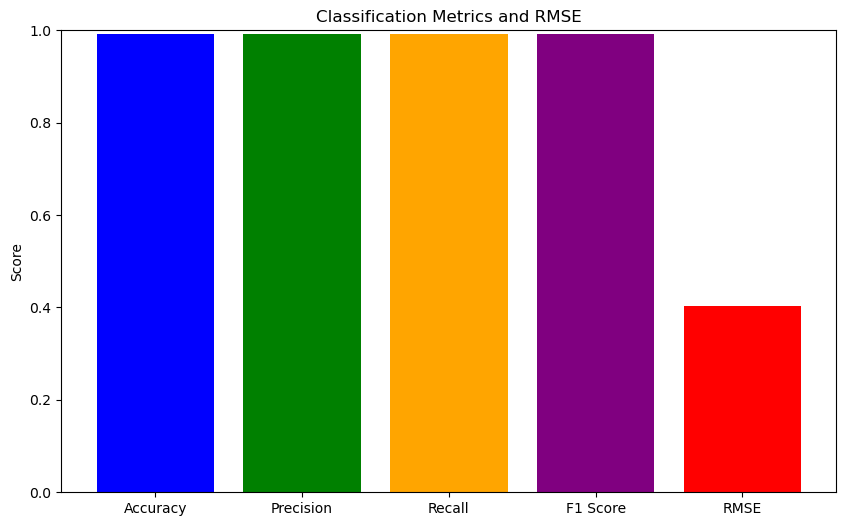

In [230]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
import numpy as np

# Convert class probabilities to predicted class labels
predicted_labels = np.argmax(combined_values, axis=1)

# Get the true labels from the test set
true_labels = np.argmax(y_test, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average='weighted')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate RMSE (using probabilities or one-hot encoded labels)
rmse = np.sqrt(mean_squared_error(y_test, combined_values))

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"RMSE: {rmse:.4f}")

# Plot the metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'RMSE']
values = [accuracy, precision, recall, f1, rmse]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'purple', 'red'])
plt.title('Classification Metrics and RMSE')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits for better visualization (except RMSE if it's high)
plt.show()

True Certainty (TC): The model correctly classifies a sample with high confidence.

True Uncertainty (TU): The model misclassifies a sample but does so with low confidence.

False Certainty (FC): The model misclassifies a sample with high confidence.

False Uncertainty (FU): The model correctly classifies a sample but does so with low confidence.

[0.20103785 0.47705663 0.51534032 0.26730238 0.15387938 0.18649324
 0.24801895 0.55321364 0.29095763 0.13535816 0.10230138 0.67517628
 0.12852379 0.34522014 0.14306142 0.21382883 0.13211747 0.
 0.03595302 0.25708792 0.31362603 0.15266898 0.19840996 0.04000842
 0.09899309 0.34389602 0.16387386 0.23889032 0.11479173 0.27958575
 0.10595056 0.0661161  0.18701644 0.11334305 0.0830705  0.11401041
 1.         0.1487171  0.48288553 0.16352411 0.07947233 0.48064761
 0.17917552 0.08976195 0.20755796 0.14035244 0.30161038 0.0250528
 0.2257407  0.19009047 0.54261728 0.2419042  0.23516808 0.44405056
 0.26499596 0.13088448 0.13451224 0.17634713 0.53403825 0.08551526
 0.13832647 0.24014266 0.24365694 0.11507711 0.07684512 0.18469977
 0.25647393 0.16117355 0.08556165 0.31089386 0.46959265 0.39935033
 0.11725178 0.35593694 0.05366248 0.25874127 0.10670293 0.2343746
 0.04417451 0.3230726  0.49960207 0.06145476 0.49119702 0.23910566
 0.75322446 0.22034563 0.26443271 0.27262342 0.15394566 0.15198113
 0.20

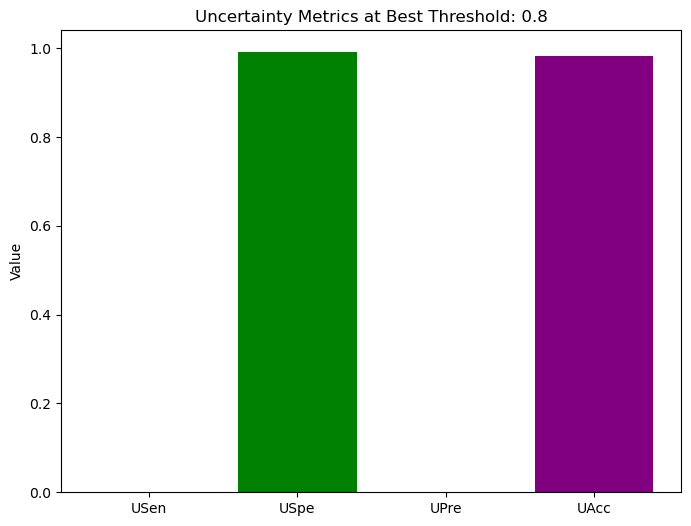

Best Threshold: 0.8
True Certainty (TC): 112, True Uncertainty (TU): 0
False Certainty (FC): 1, False Uncertainty (FU): 1
Sum of TC + TU: 112
Uncertainty Sensitivity (USen): 0.0000
Uncertainty Specificity (USpe): 0.9912
Uncertainty Precision (UPre): 0.0000
Uncertainty Accuracy (UAcc): 0.9825


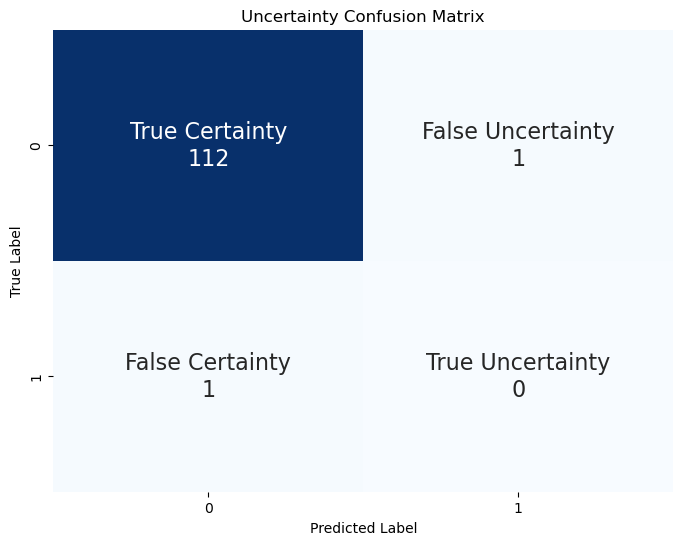

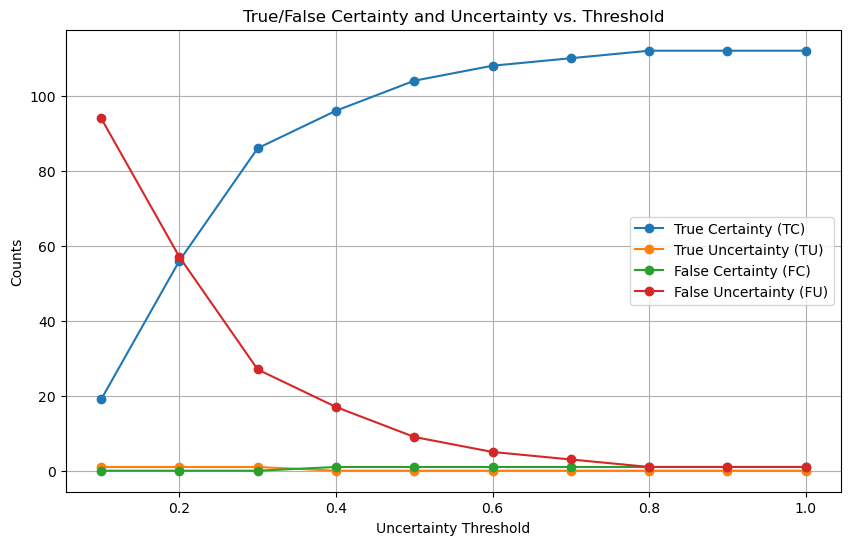

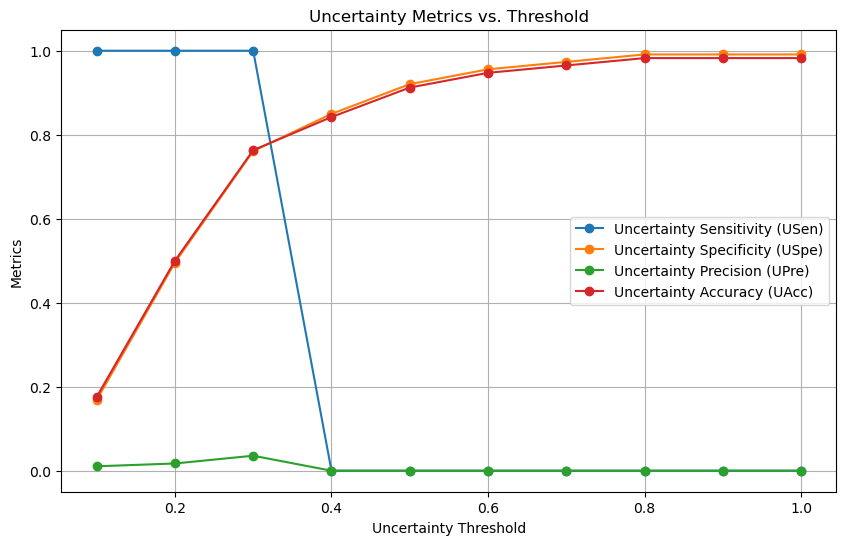

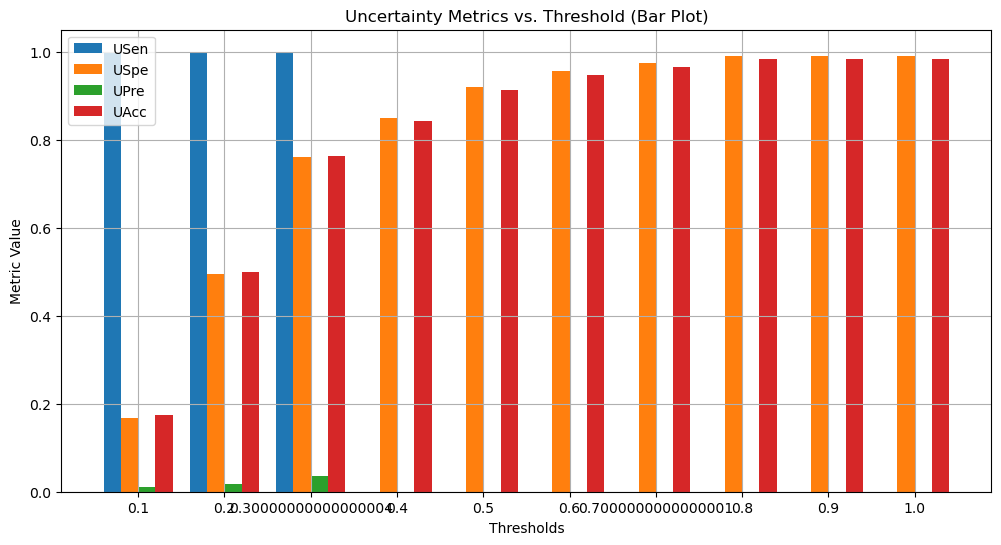

In [232]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Function to calculate uncertainty using entropy
def calculate_uncertainty(probabilities):
    return -np.sum(probabilities * np.log(probabilities + 1e-9), axis=1)  # Entropy

# Calculate uncertainties for test samples
uncertainties = calculate_uncertainty(combined_values)

# Normalize uncertainties between 0 and 1
def normalize_uncertainty(uncertainties):
    min_uncertainty = np.min(uncertainties)
    max_uncertainty = np.max(uncertainties)
    return (uncertainties - min_uncertainty) / (max_uncertainty - min_uncertainty)

normalized_uncertainties = normalize_uncertainty(uncertainties)

print(normalized_uncertainties)

# Function to find the threshold that maximizes TC + TU
def find_threshold_max_tc_tu(combined_values, true_labels, normalized_uncertainties, thresholds=np.arange(0.1, 1.1, 0.1)):
    best_threshold = 0
    best_tc_tu_sum = -np.inf
    best_tc, best_tu = 0, 0
    best_fu, best_fc = 0, 0

    for threshold in thresholds:
        TC, FU, FC, TU = 0, 0, 0, 0

        for i in range(len(true_labels)):
            pred_class = np.argmax(combined_values[i])
            true_class = true_labels[i]
            uncertainty = normalized_uncertainties[i]

            if pred_class == true_class:
                if uncertainty < threshold:
                    TC += 1
                else:
                    FU += 1
            else:
                if uncertainty < threshold:
                    FC += 1
                else:
                    TU += 1

        tc_tu_sum = TC + TU

        if tc_tu_sum > best_tc_tu_sum:
            best_threshold = threshold
            best_tc_tu_sum = tc_tu_sum
            best_tc, best_tu = TC, TU
            best_fu, best_fc = FU, FC

    return best_threshold, best_tc, best_tu, best_fu, best_fc, best_tc_tu_sum

# Function to plot TC, TU, FC, and FU vs. threshold
def plot_tc_tu(combined_values, true_labels, normalized_uncertainties, thresholds=np.arange(0.1, 1.1, 0.1)):
    tc_values = []
    tu_values = []
    fc_values = []
    fu_values = []

    for threshold in thresholds:
        TC, FU, FC, TU = 0, 0, 0, 0
        for i in range(len(true_labels)):
            pred_class = np.argmax(combined_values[i])
            true_class = true_labels[i]
            uncertainty = normalized_uncertainties[i]

            if pred_class == true_class:
                if uncertainty < threshold:
                    TC += 1
                else:
                    FU += 1
            else:
                if uncertainty < threshold:
                    FC += 1
                else:
                    TU += 1

        tc_values.append(TC)
        tu_values.append(TU)
        fc_values.append(FC)
        fu_values.append(FU)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, tc_values, label="True Certainty (TC)", marker='o')
    plt.plot(thresholds, tu_values, label="True Uncertainty (TU)", marker='o')
    plt.plot(thresholds, fc_values, label="False Certainty (FC)", marker='o')
    plt.plot(thresholds, fu_values, label="False Uncertainty (FU)", marker='o')
    plt.xlabel('Uncertainty Threshold')
    plt.ylabel('Counts')
    plt.title('True/False Certainty and Uncertainty vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(best_tc, best_tu, best_fu, best_fc):
    confusion_matrix_values = np.array([[best_tc, best_fu], [best_fc, best_tu]])
    labels = np.array([[f"True Certainty\n{best_tc}", f"False Uncertainty\n{best_fu}"],
                       [f"False Certainty\n{best_fc}", f"True Uncertainty\n{best_tu}"]])

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_values, annot=labels, fmt='', cmap='Blues', cbar=False, annot_kws={"size": 16})
    plt.title('Uncertainty Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Function to plot uncertainty metrics vs threshold
def plot_uncertainty_metrics_vs_threshold(thresholds, usen_values, uspe_values, upre_values, uacc_values):
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, usen_values, label="Uncertainty Sensitivity (USen)", marker='o')
    plt.plot(thresholds, uspe_values, label="Uncertainty Specificity (USpe)", marker='o')
    plt.plot(thresholds, upre_values, label="Uncertainty Precision (UPre)", marker='o')
    plt.plot(thresholds, uacc_values, label="Uncertainty Accuracy (UAcc)", marker='o')
    plt.xlabel('Uncertainty Threshold')
    plt.ylabel('Metrics')
    plt.title('Uncertainty Metrics vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot uncertainty metrics bar graph at best threshold
def plot_uncertainty_metrics_bar_graph(USen, USpe, UPre, UAcc):
    metrics = ['USen', 'USpe', 'UPre', 'UAcc']
    values = [USen, USpe, UPre, UAcc]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
    plt.title(f"Uncertainty Metrics at Best Threshold: {best_threshold}")
    plt.ylabel('Value')
    plt.show()
   

# Function to plot bar graph of uncertainty metrics
def plot_uncertainty_metrics_bar(thresholds, USen_values, USpe_values, UPre_values, UAcc_values):
    x = np.arange(len(thresholds))  # label locations
    width = 0.2  # width of the bars

    plt.figure(figsize=(12, 6))
    
    plt.bar(x - 1.5*width, USen_values, width, label="USen")
    plt.bar(x - 0.5*width, USpe_values, width, label="USpe")
    plt.bar(x + 0.5*width, UPre_values, width, label="UPre")
    plt.bar(x + 1.5*width, UAcc_values, width, label="UAcc")

    plt.xlabel('Thresholds')
    plt.ylabel('Metric Value')
    plt.title('Uncertainty Metrics vs. Threshold (Bar Plot)')
    plt.xticks(x, thresholds)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming these are defined:
# combined_values = np.array([[...], [...], ...])  # Model's predicted probabilities
# true_labels = np.array([...])  # True class labels

# Calculate uncertainties for test samples
#uncertainties = calculate_uncertainty(combined_values)

# Normalize the uncertainties
#normalized_uncertainties = normalize_uncertainty(uncertainties)

# Find the best threshold that maximizes TC + TU
best_threshold, best_tc, best_tu, best_fu, best_fc, best_tc_tu_sum = find_threshold_max_tc_tu(combined_values, true_labels, normalized_uncertainties)

# Calculate metrics at the best threshold
USen = best_tu / (best_tu + best_fc) if (best_tu + best_fc) != 0 else 0
USpe = best_tc / (best_tc + best_fu) if (best_tc + best_fu) != 0 else 0
UPre = best_tu / (best_tu + best_fu) if (best_tu + best_fu) != 0 else 0
UAcc = (best_tu + best_tc) / (best_tu + best_tc + best_fu + best_fc) if (best_tu + best_tc + best_fu + best_fc) != 0 else 0
# Plot the bar graph for the metrics at the best threshold
plot_uncertainty_metrics_bar_graph(USen, USpe, UPre, UAcc)
# Output the results
print(f"Best Threshold: {best_threshold}")
print(f"True Certainty (TC): {best_tc}, True Uncertainty (TU): {best_tu}")
print(f"False Certainty (FC): {best_fc}, False Uncertainty (FU): {best_fu}")
print(f"Sum of TC + TU: {best_tc_tu_sum}")
print(f"Uncertainty Sensitivity (USen): {USen:.4f}")
print(f"Uncertainty Specificity (USpe): {USpe:.4f}")
print(f"Uncertainty Precision (UPre): {UPre:.4f}")
print(f"Uncertainty Accuracy (UAcc): {UAcc:.4f}")

# Plot the confusion matrix at the best threshold
plot_confusion_matrix(best_tc, best_tu, best_fu, best_fc)

# Plot True/False Certainty and Uncertainty vs. Threshold
plot_tc_tu(combined_values, true_labels, normalized_uncertainties)

# Plot uncertainty metrics vs threshold
thresholds = np.arange(0.1, 1.1, 0.1)
USen_values = []
USpe_values = []
UPre_values = []
UAcc_values = []


for threshold in thresholds:
    _, tc, tu, fu, fc, _ = find_threshold_max_tc_tu(combined_values, true_labels, normalized_uncertainties, [threshold])
    
    USen = tu / (tu + fc) if (tu + fc) != 0 else 0
    USpe = tc / (tc + fu) if (tc + fu) != 0 else 0
    UPre = tu / (tu + fu) if (tu + fu) != 0 else 0
    UAcc = (tu + tc) / (tu + tc + fu + fc) if (tu + tc + fu + fc) != 0 else 0
    
    USen_values.append(USen)
    USpe_values.append(USpe)
    UPre_values.append(UPre)
    UAcc_values.append(UAcc)

plot_uncertainty_metrics_vs_threshold(thresholds, USen_values, USpe_values, UPre_values, UAcc_values)

# Plot the bar graph for the metrics at the best threshold
#plot_uncertainty_metrics_bar_graph(USen, USpe, UPre, UAcc)

# Plot bar graph of uncertainty metrics vs. threshold
plot_uncertainty_metrics_bar(thresholds,USen_values,USpe_values,UPre_values,UAcc_values)

In [250]:
import numpy as np
predicted_confidences = np.max(combined_values, axis=1)
predicted_labels= np.argmax(combined_values, axis=1)

def calculate_ece(true_labels ,predicted_labels,predicted_confidences, num_bins=15):
    bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = 0.0
    n = len(true_labels)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        bin_indices = np.where((predicted_confidences > bin_lower) & (predicted_confidences <= bin_upper))[0]
        if len(bin_indices) == 0:
            continue

        bin_accuracy = np.mean(true_labels[bin_indices] == predicted_labels[bin_indices])
        bin_confidence = np.mean(predicted_confidences[bin_indices])
        bin_proportion = len(bin_indices) / n

        # ECE calculation
        ece += bin_proportion * np.abs(bin_accuracy - bin_confidence)

    return ece

def calculate_oe(true_labels, predicted_labels, predicted_confidences, num_bins=15):
    bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    oe = 0.0
    n = len(true_labels)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        bin_indices = np.where((predicted_confidences > bin_lower) & (predicted_confidences <= bin_upper))[0]
        if len(bin_indices) == 0:
            continue

        bin_accuracy = np.mean(true_labels[bin_indices] == predicted_labels[bin_indices])
        bin_confidence = np.mean(predicted_confidences[bin_indices])
        bin_proportion = len(bin_indices) / n

        # OE calculation (only consider cases where confidence > accuracy)
        oe += bin_proportion * max(bin_confidence - bin_accuracy, 0)

    return oe

def calculate_ue(true_labels, predicted_labels, predicted_confidences, num_bins=15):
    bin_boundaries = np.linspace(0.0, 1.0, num_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ue = 0.0
    n = len(true_labels)

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        bin_indices = np.where((predicted_confidences > bin_lower) & (predicted_confidences <= bin_upper))[0]
        if len(bin_indices) == 0:
            continue

        bin_accuracy = np.mean(true_labels[bin_indices] == predicted_labels[bin_indices])
        bin_confidence = np.mean(predicted_confidences[bin_indices])
        bin_proportion = len(bin_indices) / n

        # UE calculation (only consider cases where accuracy > confidence)
        ue += bin_proportion * max(bin_accuracy - bin_confidence, 0)

    return ue

def negative_log_likelihood(true_labels, predicted_probabilities):

    # Ensure predicted probabilities are in a safe range to avoid log(0)
    epsilon = 1e-12
    predicted_probabilities = np.clip(predicted_probabilities, epsilon, 1. - epsilon)

    # Number of samples
    n_samples = len(true_labels)

    # Gather the predicted probabilities for the true classes
    true_class_probabilities = predicted_probabilities[np.arange(n_samples), true_labels]

    # Compute the negative log likelihood
    nll = -np.mean(np.log(true_class_probabilities))

    return nll

# Example data
#true_labels = np.array([0, 1, 0, 1, 1, 0, 1, 0])
###predicted_labels = np.array([0, 1, 0, 0, 1, 1, 1, 0])
##predicted_confidences = np.array([0.9, 0.8, 0.7, 0.6, 0.95, 0.55, 0.85, 0.5])
#predicted_probabilities = np.array([[0.9, 0.1], [0.2, 0.8], [0.7, 0.3], [0.4, 0.6], [0.05, 0.95], [0.45, 0.55], [0.15, 0.85], [0.5, 0.5]])

# Calculate metrics
ece = calculate_ece(true_labels, predicted_labels, predicted_confidences)
oe = calculate_oe(true_labels, predicted_labels, predicted_confidences)
ue = calculate_ue(true_labels, predicted_labels, predicted_confidences)
nll = negative_log_likelihood(true_labels, combined_values)

# Print results
print(f"Expected Calibration Error (ECE): {ece}")
print(f"Overconfidence Error (OE): {oe}")
print(f"Underconfidence Error (UE): {ue}")
print(f"Negative Log Likelihood (NLL): {nll}")


Expected Calibration Error (ECE): 0.2797250993131981
Overconfidence Error (OE): 0.0
Underconfidence Error (UE): 0.2797250993131981
Negative Log Likelihood (NLL): 0.3435706430880059
